In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])
plt.rcParams["figure.figsize"] = (8, 4)

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Dataset 

In [8]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../thesis/dataset/EthenT/"
postfix = "EthenT"
dim = 72
N_ELECTRONS = 16
basis = "6-311++g**"

#data_path = "../../../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

#[S, P] = np.load()
S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))


#ind = int(0.8 * len(index))
ind = 0

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))
molecules = (molecules[:ind], molecules[ind:])
#molecules = ([], molecules)

s_triu_norm, mu, std = AbstractDataset.normalize(S)

s_train, p_train, s_test, p_test = split(S.reshape(-1, dim, dim), P.reshape(-1, dim, dim), ind)
#s_test = S.reshape(-1, dim, dim)
#p_test = S.reshape(-1, dim, dim)

In [43]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities
from SCFInitialGuess.utilities.dataset import StaticDataset

dataset = StaticDataset(
    train=(s_train, p_train),
    #train=(None, None),
    validation=(None, None),
    test=(s_test, p_test),
    mu=mu,
    std=std
)

In [65]:
from pyscf.scf import hf
h_test = [hf.get_hcore(mol.get_pyscf_molecule()) for mol in molecules[1]]

# Utilities 

In [4]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd(x, y):
    p = x.copy()
    p[mask] = (y.copy())[mask]
    return p

def embedd_batch(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd(p_guess, p_conv))
    return np.array(p_embedded)


In [5]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask = np.zeros((dim, dim))

current_dim = 0
for atom in mol.species:
    
    # calculate block range
    index_start = current_dim
    current_dim += N_BASIS[basis][atom] 
    index_end = current_dim
    
    # calculate logical vector
    L = np.arange(dim)
    L = np.logical_and(index_start <= L, L < index_end)
    
    m = np.logical_and.outer(L, L)
    mask = np.logical_or(mask, m)
    
#mask

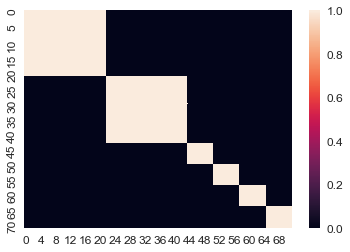

In [6]:
import seaborn as sns

sns.heatmap(mask.astype("int"))

In [8]:
np.mean(np.abs(p_test.flatten() - embedd_batch(p_test).flatten()))

0.0

In [62]:
from pyscf.scf import hf
def fock_from_density_batch(p_batch):
    f = []
    for p, s, h, mol in zip(p_batch, s_test, h_test, molecules[1]):
        f.append(hf.get_fock(None, h1e=h, s1e=s, vhf=hf.get_veff(mol=mol.get_pyscf_molecule(), dm=p), dm=p))
    return np.array(f)

In [63]:
from SCFInitialGuess.utilities.dataset import density_from_fock

def density_from_fock_batch(f_batch):
    p = []
    for (s, f, mol) in zip(s_test, f_batch, molecules[1]):
        p.append(density_from_fock(f, s, mol.get_pyscf_molecule()))
    return np.array(p)


# GWH 

In [9]:
from pyscf.scf import hf

p_gwh = np.array([ 
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

In [18]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 09:13:56: Iteration calculation: 0
[ ] 2019-01-06 09:13:57: Iteration calculation: 1
[ ] 2019-01-06 09:13:59: Iteration calculation: 2
[ ] 2019-01-06 09:14:00: Iteration calculation: 3
[ ] 2019-01-06 09:14:01: Iteration calculation: 4
[ ] 2019-01-06 09:14:02: Iteration calculation: 5
[ ] 2019-01-06 09:14:04: Iteration calculation: 6
[ ] 2019-01-06 09:14:05: Iteration calculation: 7
[ ] 2019-01-06 09:14:06: Iteration calculation: 8
[ ] 2019-01-06 09:14:07: Iteration calculation: 9
[ ] 2019-01-06 09:14:08: Iteration calculation: 10
[ ] 2019-01-06 09:14:09: Iteration calculation: 11
[ ] 2019-01-06 09:14:10: Iteration calculation: 12
[ ] 2019-01-06 09:14:12: Iteration calculation: 13
[ ] 2019-01-06 09:14:13: Iteration calculation: 14
[ ] 2019-01-06 09:14:14: Iteration calculation: 15
[ ] 2019-01-06 09:14:15: Iteration calculation: 16
[ ] 2019-01-06 09:14:17: Iteration calculation: 17
[ ] 2019-01-06 09:14:18: Iteration calculation: 18
[ ] 2019-01-06 09:14:19: Iteration calcul

[ ] 2019-01-06 09:17:10: Iteration calculation: 160
[ ] 2019-01-06 09:17:11: Iteration calculation: 161
[ ] 2019-01-06 09:17:12: Iteration calculation: 162
[ ] 2019-01-06 09:17:13: Iteration calculation: 163
[ ] 2019-01-06 09:17:14: Iteration calculation: 164
[ ] 2019-01-06 09:17:14: Iteration calculation: 165
[ ] 2019-01-06 09:17:16: Iteration calculation: 166
[ ] 2019-01-06 09:17:16: Iteration calculation: 167
[ ] 2019-01-06 09:17:17: Iteration calculation: 168
[ ] 2019-01-06 09:17:19: Iteration calculation: 169
[ ] 2019-01-06 09:17:20: Iteration calculation: 170
[ ] 2019-01-06 09:17:21: Iteration calculation: 171
[ ] 2019-01-06 09:17:23: Iteration calculation: 172
[ ] 2019-01-06 09:17:25: Iteration calculation: 173
[ ] 2019-01-06 09:17:26: Iteration calculation: 174
[ ] 2019-01-06 09:17:28: Iteration calculation: 175
[ ] 2019-01-06 09:17:29: Iteration calculation: 176
[ ] 2019-01-06 09:17:30: Iteration calculation: 177
[ ] 2019-01-06 09:17:31: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 09:20:22: Iteration calculation: 318
[ ] 2019-01-06 09:20:23: Iteration calculation: 319
[ ] 2019-01-06 09:20:24: Iteration calculation: 320
[ ] 2019-01-06 09:20:26: Iteration calculation: 321
[ ] 2019-01-06 09:20:27: Iteration calculation: 322
[ ] 2019-01-06 09:20:29: Iteration calculation: 323
[ ] 2019-01-06 09:20:30: Iteration calculation: 324
[ ] 2019-01-06 09:20:32: Iteration calculation: 325
[ ] 2019-01-06 09:20:33: Iteration calculation: 326
[ ] 2019-01-06 09:20:35: Iteration calculation: 327
[ ] 2019-01-06 09:20:36: Iteration calculation: 328
[ ] 2019-01-06 09:20:37: Iteration calculation: 329
[ ] 2019-01-06 09:20:38: Iteration calculation: 330
[ ] 2019-01-06 09:20:39: Iteration calculation: 331
[ ] 2019-01-06 09:20:40: Iteration calculation: 332
[ ] 2019-01-06 09:20:41: Iteration calculation: 333
[ ] 2019-01-06 09:20:42: Iteration calculation: 334
[ ] 2019-01-06 09:20:43: Iteration calculation: 335
[ ] 2019-01-06 09:20:43: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 09:23:35: Iteration calculation: 476
[ ] 2019-01-06 09:23:36: Iteration calculation: 477
[ ] 2019-01-06 09:23:37: Iteration calculation: 478
[ ] 2019-01-06 09:23:39: Iteration calculation: 479
[ ] 2019-01-06 09:23:39: Iteration calculation: 480
[ ] 2019-01-06 09:23:41: Iteration calculation: 481
[ ] 2019-01-06 09:23:41: Iteration calculation: 482
[ ] 2019-01-06 09:23:42: Iteration calculation: 483
[ ] 2019-01-06 09:23:43: Iteration calculation: 484
[ ] 2019-01-06 09:23:44: Iteration calculation: 485
[ ] 2019-01-06 09:23:45: Iteration calculation: 486
[ ] 2019-01-06 09:23:46: Iteration calculation: 487
[ ] 2019-01-06 09:23:47: Iteration calculation: 488
[ ] 2019-01-06 09:23:49: Iteration calculation: 489
[ ] 2019-01-06 09:23:50: Iteration calculation: 490
[ ] 2019-01-06 09:23:51: Iteration calculation: 491
[ ] 2019-01-06 09:23:52: Iteration calculation: 492
[ ] 2019-01-06 09:23:53: Iteration calculation: 493
[ ] 2019-01-06 09:23:54: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 09:26:44: Iteration calculation: 634
[ ] 2019-01-06 09:26:45: Iteration calculation: 635
[ ] 2019-01-06 09:26:46: Iteration calculation: 636
[ ] 2019-01-06 09:26:47: Iteration calculation: 637
[ ] 2019-01-06 09:26:48: Iteration calculation: 638
[ ] 2019-01-06 09:26:50: Iteration calculation: 639
[ ] 2019-01-06 09:26:51: Iteration calculation: 640
[ ] 2019-01-06 09:26:53: Iteration calculation: 641
[ ] 2019-01-06 09:26:53: Iteration calculation: 642
[ ] 2019-01-06 09:26:55: Iteration calculation: 643
[ ] 2019-01-06 09:26:56: Iteration calculation: 644
[ ] 2019-01-06 09:26:56: Iteration calculation: 645
[ ] 2019-01-06 09:26:58: Iteration calculation: 646
[ ] 2019-01-06 09:26:59: Iteration calculation: 647
[ ] 2019-01-06 09:27:01: Iteration calculation: 648
[ ] 2019-01-06 09:27:02: Iteration calculation: 649
[ ] 2019-01-06 09:27:03: Iteration calculation: 650
[ ] 2019-01-06 09:27:05: Iteration calculation: 651
[ ] 2019-01-06 09:27:06: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 09:30:02: Iteration calculation: 792
[ ] 2019-01-06 09:30:04: Iteration calculation: 793
[ ] 2019-01-06 09:30:05: Iteration calculation: 794
[ ] 2019-01-06 09:30:06: Iteration calculation: 795
[ ] 2019-01-06 09:30:07: Iteration calculation: 796
[ ] 2019-01-06 09:30:08: Iteration calculation: 797
[ ] 2019-01-06 09:30:09: Iteration calculation: 798
[ ] 2019-01-06 09:30:11: Iteration calculation: 799
[ ] 2019-01-06 09:30:12: Iteration calculation: 800
[ ] 2019-01-06 09:30:13: Iteration calculation: 801
[ ] 2019-01-06 09:30:15: Iteration calculation: 802
[ ] 2019-01-06 09:30:16: Iteration calculation: 803
[ ] 2019-01-06 09:30:18: Iteration calculation: 804
[ ] 2019-01-06 09:30:19: Iteration calculation: 805
[ ] 2019-01-06 09:30:20: Iteration calculation: 806
[ ] 2019-01-06 09:30:21: Iteration calculation: 807
[ ] 2019-01-06 09:30:23: Iteration calculation: 808
[ ] 2019-01-06 09:30:24: Iteration calculation: 809
[ ] 2019-01-06 09:30:26: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 09:33:20: Iteration calculation: 950
[ ] 2019-01-06 09:33:21: Iteration calculation: 951
[ ] 2019-01-06 09:33:22: Iteration calculation: 952
[ ] 2019-01-06 09:33:23: Iteration calculation: 953
[ ] 2019-01-06 09:33:24: Iteration calculation: 954
[ ] 2019-01-06 09:33:26: Iteration calculation: 955
[ ] 2019-01-06 09:33:27: Iteration calculation: 956
[ ] 2019-01-06 09:33:29: Iteration calculation: 957
[ ] 2019-01-06 09:33:30: Iteration calculation: 958
[ ] 2019-01-06 09:33:31: Iteration calculation: 959
[ ] 2019-01-06 09:33:32: Iteration calculation: 960
[ ] 2019-01-06 09:33:33: Iteration calculation: 961
[ ] 2019-01-06 09:33:35: Iteration calculation: 962
[ ] 2019-01-06 09:33:35: Iteration calculation: 963
[ ] 2019-01-06 09:33:37: Iteration calculation: 964
[ ] 2019-01-06 09:33:38: Iteration calculation: 965
[ ] 2019-01-06 09:33:39: Iteration calculation: 966
[ ] 2019-01-06 09:33:41: Iteration calculation: 967
[ ] 2019-01-06 09:33:42: Iteration calculation: 968
[ ] 2019-01-

# Embedded GWH 

In [38]:
p_embedded_gwh = embedd_batch(p_gwh)

In [20]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 09:41:02: Iteration calculation: 0
[ ] 2019-01-06 09:41:03: Iteration calculation: 1
[ ] 2019-01-06 09:41:03: Iteration calculation: 2
[ ] 2019-01-06 09:41:04: Iteration calculation: 3
[ ] 2019-01-06 09:41:04: Iteration calculation: 4
[ ] 2019-01-06 09:41:05: Iteration calculation: 5
[ ] 2019-01-06 09:41:06: Iteration calculation: 6
[ ] 2019-01-06 09:41:06: Iteration calculation: 7
[ ] 2019-01-06 09:41:07: Iteration calculation: 8
[ ] 2019-01-06 09:41:07: Iteration calculation: 9
[ ] 2019-01-06 09:41:08: Iteration calculation: 10
[ ] 2019-01-06 09:41:08: Iteration calculation: 11
[ ] 2019-01-06 09:41:09: Iteration calculation: 12
[ ] 2019-01-06 09:41:09: Iteration calculation: 13
[ ] 2019-01-06 09:41:10: Iteration calculation: 14
[ ] 2019-01-06 09:41:11: Iteration calculation: 15
[ ] 2019-01-06 09:41:11: Iteration calculation: 16
[ ] 2019-01-06 09:41:12: Iteration calculation: 17
[ ] 2019-01-06 09:41:12: Iteration calculation: 18
[ ] 2019-01-06 09:41:13: Iteration calcul

[ ] 2019-01-06 09:42:47: Iteration calculation: 160
[ ] 2019-01-06 09:42:48: Iteration calculation: 161
[ ] 2019-01-06 09:42:49: Iteration calculation: 162
[ ] 2019-01-06 09:42:49: Iteration calculation: 163
[ ] 2019-01-06 09:42:49: Iteration calculation: 164
[ ] 2019-01-06 09:42:50: Iteration calculation: 165
[ ] 2019-01-06 09:42:51: Iteration calculation: 166
[ ] 2019-01-06 09:42:51: Iteration calculation: 167
[ ] 2019-01-06 09:42:52: Iteration calculation: 168
[ ] 2019-01-06 09:42:52: Iteration calculation: 169
[ ] 2019-01-06 09:42:53: Iteration calculation: 170
[ ] 2019-01-06 09:42:54: Iteration calculation: 171
[ ] 2019-01-06 09:42:54: Iteration calculation: 172
[ ] 2019-01-06 09:42:55: Iteration calculation: 173
[ ] 2019-01-06 09:42:55: Iteration calculation: 174
[ ] 2019-01-06 09:42:56: Iteration calculation: 175
[ ] 2019-01-06 09:42:57: Iteration calculation: 176
[ ] 2019-01-06 09:42:57: Iteration calculation: 177
[ ] 2019-01-06 09:42:58: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 09:44:31: Iteration calculation: 318
[ ] 2019-01-06 09:44:31: Iteration calculation: 319
[ ] 2019-01-06 09:44:32: Iteration calculation: 320
[ ] 2019-01-06 09:44:32: Iteration calculation: 321
[ ] 2019-01-06 09:44:33: Iteration calculation: 322
[ ] 2019-01-06 09:44:33: Iteration calculation: 323
[ ] 2019-01-06 09:44:34: Iteration calculation: 324
[ ] 2019-01-06 09:44:35: Iteration calculation: 325
[ ] 2019-01-06 09:44:36: Iteration calculation: 326
[ ] 2019-01-06 09:44:37: Iteration calculation: 327
[ ] 2019-01-06 09:44:38: Iteration calculation: 328
[ ] 2019-01-06 09:44:39: Iteration calculation: 329
[ ] 2019-01-06 09:44:41: Iteration calculation: 330
[ ] 2019-01-06 09:44:41: Iteration calculation: 331
[ ] 2019-01-06 09:44:42: Iteration calculation: 332
[ ] 2019-01-06 09:44:43: Iteration calculation: 333
[ ] 2019-01-06 09:44:43: Iteration calculation: 334
[ ] 2019-01-06 09:44:44: Iteration calculation: 335
[ ] 2019-01-06 09:44:44: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 09:46:22: Iteration calculation: 476
[ ] 2019-01-06 09:46:23: Iteration calculation: 477
[ ] 2019-01-06 09:46:24: Iteration calculation: 478
[ ] 2019-01-06 09:46:24: Iteration calculation: 479
[ ] 2019-01-06 09:46:24: Iteration calculation: 480
[ ] 2019-01-06 09:46:25: Iteration calculation: 481
[ ] 2019-01-06 09:46:26: Iteration calculation: 482
[ ] 2019-01-06 09:46:26: Iteration calculation: 483
[ ] 2019-01-06 09:46:27: Iteration calculation: 484
[ ] 2019-01-06 09:46:27: Iteration calculation: 485
[ ] 2019-01-06 09:46:28: Iteration calculation: 486
[ ] 2019-01-06 09:46:28: Iteration calculation: 487
[ ] 2019-01-06 09:46:29: Iteration calculation: 488
[ ] 2019-01-06 09:46:29: Iteration calculation: 489
[ ] 2019-01-06 09:46:30: Iteration calculation: 490
[ ] 2019-01-06 09:46:32: Iteration calculation: 491
[ ] 2019-01-06 09:46:34: Iteration calculation: 492
[ ] 2019-01-06 09:46:35: Iteration calculation: 493
[ ] 2019-01-06 09:46:36: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 09:48:07: Iteration calculation: 634
[ ] 2019-01-06 09:48:07: Iteration calculation: 635
[ ] 2019-01-06 09:48:08: Iteration calculation: 636
[ ] 2019-01-06 09:48:09: Iteration calculation: 637
[ ] 2019-01-06 09:48:09: Iteration calculation: 638
[ ] 2019-01-06 09:48:10: Iteration calculation: 639
[ ] 2019-01-06 09:48:10: Iteration calculation: 640
[ ] 2019-01-06 09:48:11: Iteration calculation: 641
[ ] 2019-01-06 09:48:11: Iteration calculation: 642
[ ] 2019-01-06 09:48:12: Iteration calculation: 643
[ ] 2019-01-06 09:48:13: Iteration calculation: 644
[ ] 2019-01-06 09:48:13: Iteration calculation: 645
[ ] 2019-01-06 09:48:14: Iteration calculation: 646
[ ] 2019-01-06 09:48:15: Iteration calculation: 647
[ ] 2019-01-06 09:48:15: Iteration calculation: 648
[ ] 2019-01-06 09:48:16: Iteration calculation: 649
[ ] 2019-01-06 09:48:17: Iteration calculation: 650
[ ] 2019-01-06 09:48:17: Iteration calculation: 651
[ ] 2019-01-06 09:48:18: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 09:49:53: Iteration calculation: 792
[ ] 2019-01-06 09:49:54: Iteration calculation: 793
[ ] 2019-01-06 09:49:54: Iteration calculation: 794
[ ] 2019-01-06 09:49:55: Iteration calculation: 795
[ ] 2019-01-06 09:49:55: Iteration calculation: 796
[ ] 2019-01-06 09:49:56: Iteration calculation: 797
[ ] 2019-01-06 09:49:56: Iteration calculation: 798
[ ] 2019-01-06 09:49:57: Iteration calculation: 799
[ ] 2019-01-06 09:49:58: Iteration calculation: 800
[ ] 2019-01-06 09:49:58: Iteration calculation: 801
[ ] 2019-01-06 09:49:59: Iteration calculation: 802
[ ] 2019-01-06 09:50:00: Iteration calculation: 803
[ ] 2019-01-06 09:50:01: Iteration calculation: 804
[ ] 2019-01-06 09:50:02: Iteration calculation: 805
[ ] 2019-01-06 09:50:03: Iteration calculation: 806
[ ] 2019-01-06 09:50:03: Iteration calculation: 807
[ ] 2019-01-06 09:50:04: Iteration calculation: 808
[ ] 2019-01-06 09:50:05: Iteration calculation: 809
[ ] 2019-01-06 09:50:06: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 09:51:36: Iteration calculation: 950
[ ] 2019-01-06 09:51:36: Iteration calculation: 951
[ ] 2019-01-06 09:51:37: Iteration calculation: 952
[ ] 2019-01-06 09:51:37: Iteration calculation: 953
[ ] 2019-01-06 09:51:38: Iteration calculation: 954
[ ] 2019-01-06 09:51:39: Iteration calculation: 955
[ ] 2019-01-06 09:51:40: Iteration calculation: 956
[ ] 2019-01-06 09:51:40: Iteration calculation: 957
[ ] 2019-01-06 09:51:41: Iteration calculation: 958
[ ] 2019-01-06 09:51:42: Iteration calculation: 959
[ ] 2019-01-06 09:51:42: Iteration calculation: 960
[ ] 2019-01-06 09:51:43: Iteration calculation: 961
[ ] 2019-01-06 09:51:43: Iteration calculation: 962
[ ] 2019-01-06 09:51:44: Iteration calculation: 963
[ ] 2019-01-06 09:51:45: Iteration calculation: 964
[ ] 2019-01-06 09:51:46: Iteration calculation: 965
[ ] 2019-01-06 09:51:46: Iteration calculation: 966
[ ] 2019-01-06 09:51:46: Iteration calculation: 967
[ ] 2019-01-06 09:51:47: Iteration calculation: 968
[ ] 2019-01-

In [21]:
51/1001

0.05094905094905095

# Embedded GWH + 1 Iteration

In [22]:
f_embedded_gwh = fock_from_density_batch(p_embedded_gwh)
p_embedded_gwh_test = density_from_fock_batch(f_embedded_gwh)

In [23]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_gwh_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 10:03:33: Iteration calculation: 0
[ ] 2019-01-06 10:03:34: Iteration calculation: 1
[ ] 2019-01-06 10:03:34: Iteration calculation: 2
[ ] 2019-01-06 10:03:35: Iteration calculation: 3
[ ] 2019-01-06 10:03:36: Iteration calculation: 4
[ ] 2019-01-06 10:03:37: Iteration calculation: 5
[ ] 2019-01-06 10:03:38: Iteration calculation: 6
[ ] 2019-01-06 10:03:39: Iteration calculation: 7
[ ] 2019-01-06 10:03:39: Iteration calculation: 8
[ ] 2019-01-06 10:03:40: Iteration calculation: 9
[ ] 2019-01-06 10:03:41: Iteration calculation: 10
[ ] 2019-01-06 10:03:42: Iteration calculation: 11
[ ] 2019-01-06 10:03:42: Iteration calculation: 12
[ ] 2019-01-06 10:03:43: Iteration calculation: 13
[ ] 2019-01-06 10:03:43: Iteration calculation: 14
[ ] 2019-01-06 10:03:44: Iteration calculation: 15
[ ] 2019-01-06 10:03:45: Iteration calculation: 16
[ ] 2019-01-06 10:03:45: Iteration calculation: 17
[ ] 2019-01-06 10:03:46: Iteration calculation: 18
[ ] 2019-01-06 10:03:47: Iteration calcul

[ ] 2019-01-06 10:05:23: Iteration calculation: 160
[ ] 2019-01-06 10:05:24: Iteration calculation: 161
[ ] 2019-01-06 10:05:24: Iteration calculation: 162
[ ] 2019-01-06 10:05:25: Iteration calculation: 163
[ ] 2019-01-06 10:05:25: Iteration calculation: 164
[ ] 2019-01-06 10:05:26: Iteration calculation: 165
[ ] 2019-01-06 10:05:26: Iteration calculation: 166
[ ] 2019-01-06 10:05:27: Iteration calculation: 167
[ ] 2019-01-06 10:05:27: Iteration calculation: 168
[ ] 2019-01-06 10:05:28: Iteration calculation: 169
[ ] 2019-01-06 10:05:29: Iteration calculation: 170
[ ] 2019-01-06 10:05:29: Iteration calculation: 171
[ ] 2019-01-06 10:05:30: Iteration calculation: 172
[ ] 2019-01-06 10:05:30: Iteration calculation: 173
[ ] 2019-01-06 10:05:31: Iteration calculation: 174
[ ] 2019-01-06 10:05:32: Iteration calculation: 175
[ ] 2019-01-06 10:05:32: Iteration calculation: 176
[ ] 2019-01-06 10:05:33: Iteration calculation: 177
[ ] 2019-01-06 10:05:33: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 10:07:04: Iteration calculation: 318
[ ] 2019-01-06 10:07:04: Iteration calculation: 319
[ ] 2019-01-06 10:07:05: Iteration calculation: 320
[ ] 2019-01-06 10:07:05: Iteration calculation: 321
[ ] 2019-01-06 10:07:06: Iteration calculation: 322
[ ] 2019-01-06 10:07:06: Iteration calculation: 323
[ ] 2019-01-06 10:07:07: Iteration calculation: 324
[ ] 2019-01-06 10:07:07: Iteration calculation: 325
[ ] 2019-01-06 10:07:08: Iteration calculation: 326
[ ] 2019-01-06 10:07:08: Iteration calculation: 327
[ ] 2019-01-06 10:07:09: Iteration calculation: 328
[ ] 2019-01-06 10:07:09: Iteration calculation: 329
[ ] 2019-01-06 10:07:10: Iteration calculation: 330
[ ] 2019-01-06 10:07:10: Iteration calculation: 331
[ ] 2019-01-06 10:07:11: Iteration calculation: 332
[ ] 2019-01-06 10:07:11: Iteration calculation: 333
[ ] 2019-01-06 10:07:12: Iteration calculation: 334
[ ] 2019-01-06 10:07:12: Iteration calculation: 335
[ ] 2019-01-06 10:07:13: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 10:08:54: Iteration calculation: 476
[ ] 2019-01-06 10:08:55: Iteration calculation: 477
[ ] 2019-01-06 10:08:56: Iteration calculation: 478
[ ] 2019-01-06 10:08:56: Iteration calculation: 479
[ ] 2019-01-06 10:08:57: Iteration calculation: 480
[ ] 2019-01-06 10:08:58: Iteration calculation: 481
[ ] 2019-01-06 10:08:58: Iteration calculation: 482
[ ] 2019-01-06 10:08:58: Iteration calculation: 483
[ ] 2019-01-06 10:08:59: Iteration calculation: 484
[ ] 2019-01-06 10:09:00: Iteration calculation: 485
[ ] 2019-01-06 10:09:00: Iteration calculation: 486
[ ] 2019-01-06 10:09:00: Iteration calculation: 487
[ ] 2019-01-06 10:09:01: Iteration calculation: 488
[ ] 2019-01-06 10:09:01: Iteration calculation: 489
[ ] 2019-01-06 10:09:02: Iteration calculation: 490
[ ] 2019-01-06 10:09:03: Iteration calculation: 491
[ ] 2019-01-06 10:09:04: Iteration calculation: 492
[ ] 2019-01-06 10:09:05: Iteration calculation: 493
[ ] 2019-01-06 10:09:06: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 10:10:41: Iteration calculation: 634
[ ] 2019-01-06 10:10:42: Iteration calculation: 635
[ ] 2019-01-06 10:10:42: Iteration calculation: 636
[ ] 2019-01-06 10:10:43: Iteration calculation: 637
[ ] 2019-01-06 10:10:43: Iteration calculation: 638
[ ] 2019-01-06 10:10:44: Iteration calculation: 639
[ ] 2019-01-06 10:10:44: Iteration calculation: 640
[ ] 2019-01-06 10:10:45: Iteration calculation: 641
[ ] 2019-01-06 10:10:45: Iteration calculation: 642
[ ] 2019-01-06 10:10:46: Iteration calculation: 643
[ ] 2019-01-06 10:10:47: Iteration calculation: 644
[ ] 2019-01-06 10:10:47: Iteration calculation: 645
[ ] 2019-01-06 10:10:48: Iteration calculation: 646
[ ] 2019-01-06 10:10:48: Iteration calculation: 647
[ ] 2019-01-06 10:10:49: Iteration calculation: 648
[ ] 2019-01-06 10:10:49: Iteration calculation: 649
[ ] 2019-01-06 10:10:51: Iteration calculation: 650
[ ] 2019-01-06 10:10:52: Iteration calculation: 651
[ ] 2019-01-06 10:10:52: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 10:12:26: Iteration calculation: 792
[ ] 2019-01-06 10:12:27: Iteration calculation: 793
[ ] 2019-01-06 10:12:28: Iteration calculation: 794
[ ] 2019-01-06 10:12:28: Iteration calculation: 795
[ ] 2019-01-06 10:12:28: Iteration calculation: 796
[ ] 2019-01-06 10:12:29: Iteration calculation: 797
[ ] 2019-01-06 10:12:30: Iteration calculation: 798
[ ] 2019-01-06 10:12:31: Iteration calculation: 799
[ ] 2019-01-06 10:12:31: Iteration calculation: 800
[ ] 2019-01-06 10:12:32: Iteration calculation: 801
[ ] 2019-01-06 10:12:32: Iteration calculation: 802
[ ] 2019-01-06 10:12:33: Iteration calculation: 803
[ ] 2019-01-06 10:12:34: Iteration calculation: 804
[ ] 2019-01-06 10:12:35: Iteration calculation: 805
[ ] 2019-01-06 10:12:35: Iteration calculation: 806
[ ] 2019-01-06 10:12:36: Iteration calculation: 807
[ ] 2019-01-06 10:12:36: Iteration calculation: 808
[ ] 2019-01-06 10:12:37: Iteration calculation: 809
[ ] 2019-01-06 10:12:38: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 10:14:07: Iteration calculation: 950
[ ] 2019-01-06 10:14:08: Iteration calculation: 951
[ ] 2019-01-06 10:14:08: Iteration calculation: 952
[ ] 2019-01-06 10:14:09: Iteration calculation: 953
[ ] 2019-01-06 10:14:09: Iteration calculation: 954
[ ] 2019-01-06 10:14:10: Iteration calculation: 955
[ ] 2019-01-06 10:14:11: Iteration calculation: 956
[ ] 2019-01-06 10:14:12: Iteration calculation: 957
[ ] 2019-01-06 10:14:12: Iteration calculation: 958
[ ] 2019-01-06 10:14:13: Iteration calculation: 959
[ ] 2019-01-06 10:14:13: Iteration calculation: 960
[ ] 2019-01-06 10:14:14: Iteration calculation: 961
[ ] 2019-01-06 10:14:14: Iteration calculation: 962
[ ] 2019-01-06 10:14:15: Iteration calculation: 963
[ ] 2019-01-06 10:14:16: Iteration calculation: 964
[ ] 2019-01-06 10:14:17: Iteration calculation: 965
[ ] 2019-01-06 10:14:17: Iteration calculation: 966
[ ] 2019-01-06 10:14:18: Iteration calculation: 967
[ ] 2019-01-06 10:14:18: Iteration calculation: 968
[ ] 2019-01-

# SAD 

In [24]:
from pyscf.scf import hf

p_sad = np.array([ 
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
]).astype("float64")

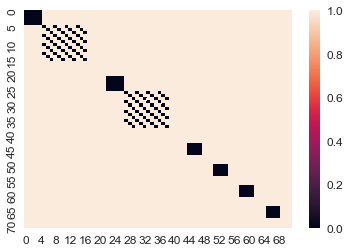

In [25]:
sns.heatmap((abs(p_sad[0]) < 1e-12).astype("int"))

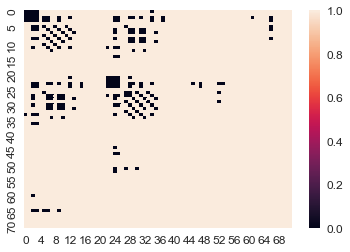

In [26]:
sns.heatmap((abs(p_gwh[0]) < 0.05).astype("int"))

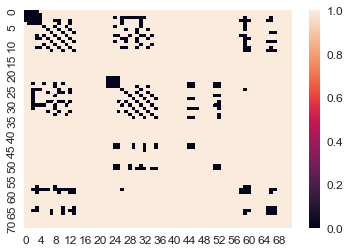

In [27]:
sns.heatmap((abs(p_test[30]) < 0.05).astype("int"))

In [28]:
from SCFInitialGuess.utilities.analysis import make_results_str, measure_all_quantities, mf_initializer

print(make_results_str(measure_all_quantities(
    p_sad,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 10:23:32: Iteration calculation: 0
[ ] 2019-01-06 10:23:32: Iteration calculation: 1
[ ] 2019-01-06 10:23:33: Iteration calculation: 2
[ ] 2019-01-06 10:23:34: Iteration calculation: 3
[ ] 2019-01-06 10:23:34: Iteration calculation: 4
[ ] 2019-01-06 10:23:35: Iteration calculation: 5
[ ] 2019-01-06 10:23:35: Iteration calculation: 6
[ ] 2019-01-06 10:23:36: Iteration calculation: 7
[ ] 2019-01-06 10:23:36: Iteration calculation: 8
[ ] 2019-01-06 10:23:37: Iteration calculation: 9
[ ] 2019-01-06 10:23:37: Iteration calculation: 10
[ ] 2019-01-06 10:23:38: Iteration calculation: 11
[ ] 2019-01-06 10:23:38: Iteration calculation: 12
[ ] 2019-01-06 10:23:39: Iteration calculation: 13
[ ] 2019-01-06 10:23:39: Iteration calculation: 14
[ ] 2019-01-06 10:23:40: Iteration calculation: 15
[ ] 2019-01-06 10:23:41: Iteration calculation: 16
[ ] 2019-01-06 10:23:41: Iteration calculation: 17
[ ] 2019-01-06 10:23:42: Iteration calculation: 18
[ ] 2019-01-06 10:23:42: Iteration calcul

[ ] 2019-01-06 10:25:19: Iteration calculation: 160
[ ] 2019-01-06 10:25:20: Iteration calculation: 161
[ ] 2019-01-06 10:25:21: Iteration calculation: 162
[ ] 2019-01-06 10:25:21: Iteration calculation: 163
[ ] 2019-01-06 10:25:22: Iteration calculation: 164
[ ] 2019-01-06 10:25:23: Iteration calculation: 165
[ ] 2019-01-06 10:25:23: Iteration calculation: 166
[ ] 2019-01-06 10:25:24: Iteration calculation: 167
[ ] 2019-01-06 10:25:24: Iteration calculation: 168
[ ] 2019-01-06 10:25:25: Iteration calculation: 169
[ ] 2019-01-06 10:25:25: Iteration calculation: 170
[ ] 2019-01-06 10:25:26: Iteration calculation: 171
[ ] 2019-01-06 10:25:27: Iteration calculation: 172
[ ] 2019-01-06 10:25:27: Iteration calculation: 173
[ ] 2019-01-06 10:25:28: Iteration calculation: 174
[ ] 2019-01-06 10:25:29: Iteration calculation: 175
[ ] 2019-01-06 10:25:30: Iteration calculation: 176
[ ] 2019-01-06 10:25:30: Iteration calculation: 177
[ ] 2019-01-06 10:25:30: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 10:27:00: Iteration calculation: 318
[ ] 2019-01-06 10:27:00: Iteration calculation: 319
[ ] 2019-01-06 10:27:01: Iteration calculation: 320
[ ] 2019-01-06 10:27:02: Iteration calculation: 321
[ ] 2019-01-06 10:27:03: Iteration calculation: 322
[ ] 2019-01-06 10:27:03: Iteration calculation: 323
[ ] 2019-01-06 10:27:04: Iteration calculation: 324
[ ] 2019-01-06 10:27:04: Iteration calculation: 325
[ ] 2019-01-06 10:27:05: Iteration calculation: 326
[ ] 2019-01-06 10:27:05: Iteration calculation: 327
[ ] 2019-01-06 10:27:06: Iteration calculation: 328
[ ] 2019-01-06 10:27:06: Iteration calculation: 329
[ ] 2019-01-06 10:27:07: Iteration calculation: 330
[ ] 2019-01-06 10:27:08: Iteration calculation: 331
[ ] 2019-01-06 10:27:08: Iteration calculation: 332
[ ] 2019-01-06 10:27:09: Iteration calculation: 333
[ ] 2019-01-06 10:27:09: Iteration calculation: 334
[ ] 2019-01-06 10:27:10: Iteration calculation: 335
[ ] 2019-01-06 10:27:10: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 10:28:48: Iteration calculation: 476
[ ] 2019-01-06 10:28:48: Iteration calculation: 477
[ ] 2019-01-06 10:28:49: Iteration calculation: 478
[ ] 2019-01-06 10:28:49: Iteration calculation: 479
[ ] 2019-01-06 10:28:50: Iteration calculation: 480
[ ] 2019-01-06 10:28:52: Iteration calculation: 481
[ ] 2019-01-06 10:28:52: Iteration calculation: 482
[ ] 2019-01-06 10:28:53: Iteration calculation: 483
[ ] 2019-01-06 10:28:54: Iteration calculation: 484
[ ] 2019-01-06 10:28:54: Iteration calculation: 485
[ ] 2019-01-06 10:28:55: Iteration calculation: 486
[ ] 2019-01-06 10:28:55: Iteration calculation: 487
[ ] 2019-01-06 10:28:56: Iteration calculation: 488
[ ] 2019-01-06 10:28:57: Iteration calculation: 489
[ ] 2019-01-06 10:28:57: Iteration calculation: 490
[ ] 2019-01-06 10:28:58: Iteration calculation: 491
[ ] 2019-01-06 10:29:00: Iteration calculation: 492
[ ] 2019-01-06 10:29:00: Iteration calculation: 493
[ ] 2019-01-06 10:29:01: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 10:30:36: Iteration calculation: 634
[ ] 2019-01-06 10:30:37: Iteration calculation: 635
[ ] 2019-01-06 10:30:37: Iteration calculation: 636
[ ] 2019-01-06 10:30:38: Iteration calculation: 637
[ ] 2019-01-06 10:30:38: Iteration calculation: 638
[ ] 2019-01-06 10:30:39: Iteration calculation: 639
[ ] 2019-01-06 10:30:39: Iteration calculation: 640
[ ] 2019-01-06 10:30:40: Iteration calculation: 641
[ ] 2019-01-06 10:30:40: Iteration calculation: 642
[ ] 2019-01-06 10:30:41: Iteration calculation: 643
[ ] 2019-01-06 10:30:42: Iteration calculation: 644
[ ] 2019-01-06 10:30:42: Iteration calculation: 645
[ ] 2019-01-06 10:30:43: Iteration calculation: 646
[ ] 2019-01-06 10:30:43: Iteration calculation: 647
[ ] 2019-01-06 10:30:44: Iteration calculation: 648
[ ] 2019-01-06 10:30:44: Iteration calculation: 649
[ ] 2019-01-06 10:30:46: Iteration calculation: 650
[ ] 2019-01-06 10:30:46: Iteration calculation: 651
[ ] 2019-01-06 10:30:46: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 10:32:20: Iteration calculation: 792
[ ] 2019-01-06 10:32:21: Iteration calculation: 793
[ ] 2019-01-06 10:32:22: Iteration calculation: 794
[ ] 2019-01-06 10:32:22: Iteration calculation: 795
[ ] 2019-01-06 10:32:22: Iteration calculation: 796
[ ] 2019-01-06 10:32:23: Iteration calculation: 797
[ ] 2019-01-06 10:32:23: Iteration calculation: 798
[ ] 2019-01-06 10:32:24: Iteration calculation: 799
[ ] 2019-01-06 10:32:24: Iteration calculation: 800
[ ] 2019-01-06 10:32:25: Iteration calculation: 801
[ ] 2019-01-06 10:32:26: Iteration calculation: 802
[ ] 2019-01-06 10:32:27: Iteration calculation: 803
[ ] 2019-01-06 10:32:27: Iteration calculation: 804
[ ] 2019-01-06 10:32:28: Iteration calculation: 805
[ ] 2019-01-06 10:32:29: Iteration calculation: 806
[ ] 2019-01-06 10:32:30: Iteration calculation: 807
[ ] 2019-01-06 10:32:30: Iteration calculation: 808
[ ] 2019-01-06 10:32:31: Iteration calculation: 809
[ ] 2019-01-06 10:32:32: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 10:34:01: Iteration calculation: 950
[ ] 2019-01-06 10:34:01: Iteration calculation: 951
[ ] 2019-01-06 10:34:02: Iteration calculation: 952
[ ] 2019-01-06 10:34:02: Iteration calculation: 953
[ ] 2019-01-06 10:34:03: Iteration calculation: 954
[ ] 2019-01-06 10:34:03: Iteration calculation: 955
[ ] 2019-01-06 10:34:05: Iteration calculation: 956
[ ] 2019-01-06 10:34:05: Iteration calculation: 957
[ ] 2019-01-06 10:34:06: Iteration calculation: 958
[ ] 2019-01-06 10:34:06: Iteration calculation: 959
[ ] 2019-01-06 10:34:06: Iteration calculation: 960
[ ] 2019-01-06 10:34:07: Iteration calculation: 961
[ ] 2019-01-06 10:34:07: Iteration calculation: 962
[ ] 2019-01-06 10:34:08: Iteration calculation: 963
[ ] 2019-01-06 10:34:09: Iteration calculation: 964
[ ] 2019-01-06 10:34:10: Iteration calculation: 965
[ ] 2019-01-06 10:34:10: Iteration calculation: 966
[ ] 2019-01-06 10:34:11: Iteration calculation: 967
[ ] 2019-01-06 10:34:11: Iteration calculation: 968
[ ] 2019-01-

In [72]:
47/1001

0.04695304695304695

# Embedded zeros 

In [29]:
p_embedded_zeros = embedd_batch(np.zeros(p_test.shape))

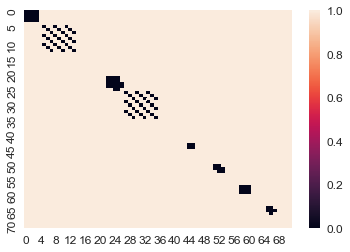

In [30]:
sns.heatmap((abs(p_embedded_zeros[0]) < 0.05).astype("int"))

In [31]:
from SCFInitialGuess.utilities.analysis import mf_initializer as mf_initializer

print(make_results_str(measure_all_quantities(
    p_embedded_zeros,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 10:41:34: Iteration calculation: 0
[ ] 2019-01-06 10:41:35: Iteration calculation: 1
[ ] 2019-01-06 10:41:35: Iteration calculation: 2
[ ] 2019-01-06 10:41:36: Iteration calculation: 3
[ ] 2019-01-06 10:41:37: Iteration calculation: 4
[ ] 2019-01-06 10:41:38: Iteration calculation: 5
[ ] 2019-01-06 10:41:39: Iteration calculation: 6
[ ] 2019-01-06 10:41:39: Iteration calculation: 7
[ ] 2019-01-06 10:41:41: Iteration calculation: 8
[ ] 2019-01-06 10:41:41: Iteration calculation: 9
[ ] 2019-01-06 10:41:42: Iteration calculation: 10
[ ] 2019-01-06 10:41:43: Iteration calculation: 11
[ ] 2019-01-06 10:41:43: Iteration calculation: 12
[ ] 2019-01-06 10:41:43: Iteration calculation: 13
[ ] 2019-01-06 10:41:44: Iteration calculation: 14
[ ] 2019-01-06 10:41:45: Iteration calculation: 15
[ ] 2019-01-06 10:41:45: Iteration calculation: 16
[ ] 2019-01-06 10:41:46: Iteration calculation: 17
[ ] 2019-01-06 10:41:47: Iteration calculation: 18
[ ] 2019-01-06 10:41:48: Iteration calcul

[ ] 2019-01-06 10:43:32: Iteration calculation: 160
[ ] 2019-01-06 10:43:33: Iteration calculation: 161
[ ] 2019-01-06 10:43:34: Iteration calculation: 162
[ ] 2019-01-06 10:43:34: Iteration calculation: 163
[ ] 2019-01-06 10:43:34: Iteration calculation: 164
[ ] 2019-01-06 10:43:35: Iteration calculation: 165
[ ] 2019-01-06 10:43:35: Iteration calculation: 166
[ ] 2019-01-06 10:43:36: Iteration calculation: 167
[ ] 2019-01-06 10:43:36: Iteration calculation: 168
[ ] 2019-01-06 10:43:37: Iteration calculation: 169
[ ] 2019-01-06 10:43:38: Iteration calculation: 170
[ ] 2019-01-06 10:43:39: Iteration calculation: 171
[ ] 2019-01-06 10:43:40: Iteration calculation: 172
[ ] 2019-01-06 10:43:40: Iteration calculation: 173
[ ] 2019-01-06 10:43:41: Iteration calculation: 174
[ ] 2019-01-06 10:43:42: Iteration calculation: 175
[ ] 2019-01-06 10:43:42: Iteration calculation: 176
[ ] 2019-01-06 10:43:43: Iteration calculation: 177
[ ] 2019-01-06 10:43:43: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 10:45:23: Iteration calculation: 318
[ ] 2019-01-06 10:45:24: Iteration calculation: 319
[ ] 2019-01-06 10:45:25: Iteration calculation: 320
[ ] 2019-01-06 10:45:26: Iteration calculation: 321
[ ] 2019-01-06 10:45:26: Iteration calculation: 322
[ ] 2019-01-06 10:45:27: Iteration calculation: 323
[ ] 2019-01-06 10:45:28: Iteration calculation: 324
[ ] 2019-01-06 10:45:28: Iteration calculation: 325
[ ] 2019-01-06 10:45:29: Iteration calculation: 326
[ ] 2019-01-06 10:45:30: Iteration calculation: 327
[ ] 2019-01-06 10:45:31: Iteration calculation: 328
[ ] 2019-01-06 10:45:31: Iteration calculation: 329
[ ] 2019-01-06 10:45:32: Iteration calculation: 330
[ ] 2019-01-06 10:45:33: Iteration calculation: 331
[ ] 2019-01-06 10:45:33: Iteration calculation: 332
[ ] 2019-01-06 10:45:34: Iteration calculation: 333
[ ] 2019-01-06 10:45:34: Iteration calculation: 334
[ ] 2019-01-06 10:45:35: Iteration calculation: 335
[ ] 2019-01-06 10:45:35: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 10:47:18: Iteration calculation: 476
[ ] 2019-01-06 10:47:19: Iteration calculation: 477
[ ] 2019-01-06 10:47:20: Iteration calculation: 478
[ ] 2019-01-06 10:47:20: Iteration calculation: 479
[ ] 2019-01-06 10:47:21: Iteration calculation: 480
[ ] 2019-01-06 10:47:22: Iteration calculation: 481
[ ] 2019-01-06 10:47:22: Iteration calculation: 482
[ ] 2019-01-06 10:47:23: Iteration calculation: 483
[ ] 2019-01-06 10:47:23: Iteration calculation: 484
[ ] 2019-01-06 10:47:24: Iteration calculation: 485
[ ] 2019-01-06 10:47:24: Iteration calculation: 486
[ ] 2019-01-06 10:47:25: Iteration calculation: 487
[ ] 2019-01-06 10:47:26: Iteration calculation: 488
[ ] 2019-01-06 10:47:26: Iteration calculation: 489
[ ] 2019-01-06 10:47:27: Iteration calculation: 490
[ ] 2019-01-06 10:47:28: Iteration calculation: 491
[ ] 2019-01-06 10:47:29: Iteration calculation: 492
[ ] 2019-01-06 10:47:29: Iteration calculation: 493
[ ] 2019-01-06 10:47:31: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 10:49:23: Iteration calculation: 634
[ ] 2019-01-06 10:49:23: Iteration calculation: 635
[ ] 2019-01-06 10:49:24: Iteration calculation: 636
[ ] 2019-01-06 10:49:25: Iteration calculation: 637
[ ] 2019-01-06 10:49:26: Iteration calculation: 638
[ ] 2019-01-06 10:49:26: Iteration calculation: 639
[ ] 2019-01-06 10:49:27: Iteration calculation: 640
[ ] 2019-01-06 10:49:27: Iteration calculation: 641
[ ] 2019-01-06 10:49:28: Iteration calculation: 642
[ ] 2019-01-06 10:49:29: Iteration calculation: 643
[ ] 2019-01-06 10:49:30: Iteration calculation: 644
[ ] 2019-01-06 10:49:30: Iteration calculation: 645
[ ] 2019-01-06 10:49:31: Iteration calculation: 646
[ ] 2019-01-06 10:49:31: Iteration calculation: 647
[ ] 2019-01-06 10:49:32: Iteration calculation: 648
[ ] 2019-01-06 10:49:33: Iteration calculation: 649
[ ] 2019-01-06 10:49:34: Iteration calculation: 650
[ ] 2019-01-06 10:49:35: Iteration calculation: 651
[ ] 2019-01-06 10:49:35: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 10:51:22: Iteration calculation: 792
[ ] 2019-01-06 10:51:24: Iteration calculation: 793
[ ] 2019-01-06 10:51:25: Iteration calculation: 794
[ ] 2019-01-06 10:51:25: Iteration calculation: 795
[ ] 2019-01-06 10:51:26: Iteration calculation: 796
[ ] 2019-01-06 10:51:27: Iteration calculation: 797
[ ] 2019-01-06 10:51:28: Iteration calculation: 798
[ ] 2019-01-06 10:51:29: Iteration calculation: 799
[ ] 2019-01-06 10:51:30: Iteration calculation: 800
[ ] 2019-01-06 10:51:31: Iteration calculation: 801
[ ] 2019-01-06 10:51:32: Iteration calculation: 802
[ ] 2019-01-06 10:51:32: Iteration calculation: 803
[ ] 2019-01-06 10:51:33: Iteration calculation: 804
[ ] 2019-01-06 10:51:34: Iteration calculation: 805
[ ] 2019-01-06 10:51:35: Iteration calculation: 806
[ ] 2019-01-06 10:51:35: Iteration calculation: 807
[ ] 2019-01-06 10:51:36: Iteration calculation: 808
[ ] 2019-01-06 10:51:36: Iteration calculation: 809
[ ] 2019-01-06 10:51:37: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 10:53:14: Iteration calculation: 950
[ ] 2019-01-06 10:53:14: Iteration calculation: 951
[ ] 2019-01-06 10:53:15: Iteration calculation: 952
[ ] 2019-01-06 10:53:15: Iteration calculation: 953
[ ] 2019-01-06 10:53:16: Iteration calculation: 954
[ ] 2019-01-06 10:53:17: Iteration calculation: 955
[ ] 2019-01-06 10:53:18: Iteration calculation: 956
[ ] 2019-01-06 10:53:18: Iteration calculation: 957
[ ] 2019-01-06 10:53:19: Iteration calculation: 958
[ ] 2019-01-06 10:53:20: Iteration calculation: 959
[ ] 2019-01-06 10:53:20: Iteration calculation: 960
[ ] 2019-01-06 10:53:21: Iteration calculation: 961
[ ] 2019-01-06 10:53:21: Iteration calculation: 962
[ ] 2019-01-06 10:53:22: Iteration calculation: 963
[ ] 2019-01-06 10:53:23: Iteration calculation: 964
[ ] 2019-01-06 10:53:23: Iteration calculation: 965
[ ] 2019-01-06 10:53:24: Iteration calculation: 966
[ ] 2019-01-06 10:53:24: Iteration calculation: 967
[ ] 2019-01-06 10:53:25: Iteration calculation: 968
[ ] 2019-01-

# Embedded zeros + 1 Iteration? 

In [32]:
f_embedded_zeros = fock_from_density_batch(p_embedded_zeros)
p_embedded_zeros_test = density_from_fock_batch(f_embedded_zeros,)

In [33]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    p_embedded_zeros_test,
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-06 11:05:38: Iteration calculation: 0
[ ] 2019-01-06 11:05:38: Iteration calculation: 1
[ ] 2019-01-06 11:05:39: Iteration calculation: 2
[ ] 2019-01-06 11:05:40: Iteration calculation: 3
[ ] 2019-01-06 11:05:41: Iteration calculation: 4
[ ] 2019-01-06 11:05:42: Iteration calculation: 5
[ ] 2019-01-06 11:05:43: Iteration calculation: 6
[ ] 2019-01-06 11:05:43: Iteration calculation: 7
[ ] 2019-01-06 11:05:44: Iteration calculation: 8
[ ] 2019-01-06 11:05:45: Iteration calculation: 9
[ ] 2019-01-06 11:05:46: Iteration calculation: 10
[ ] 2019-01-06 11:05:46: Iteration calculation: 11
[ ] 2019-01-06 11:05:46: Iteration calculation: 12
[ ] 2019-01-06 11:05:47: Iteration calculation: 13
[ ] 2019-01-06 11:05:47: Iteration calculation: 14
[ ] 2019-01-06 11:05:48: Iteration calculation: 15
[ ] 2019-01-06 11:05:49: Iteration calculation: 16
[ ] 2019-01-06 11:05:49: Iteration calculation: 17
[ ] 2019-01-06 11:05:51: Iteration calculation: 18
[ ] 2019-01-06 11:05:52: Iteration calcul

[ ] 2019-01-06 11:07:37: Iteration calculation: 160
[ ] 2019-01-06 11:07:38: Iteration calculation: 161
[ ] 2019-01-06 11:07:38: Iteration calculation: 162
[ ] 2019-01-06 11:07:39: Iteration calculation: 163
[ ] 2019-01-06 11:07:39: Iteration calculation: 164
[ ] 2019-01-06 11:07:40: Iteration calculation: 165
[ ] 2019-01-06 11:07:40: Iteration calculation: 166
[ ] 2019-01-06 11:07:40: Iteration calculation: 167
[ ] 2019-01-06 11:07:41: Iteration calculation: 168
[ ] 2019-01-06 11:07:41: Iteration calculation: 169
[ ] 2019-01-06 11:07:42: Iteration calculation: 170
[ ] 2019-01-06 11:07:43: Iteration calculation: 171
[ ] 2019-01-06 11:07:44: Iteration calculation: 172
[ ] 2019-01-06 11:07:45: Iteration calculation: 173
[ ] 2019-01-06 11:07:45: Iteration calculation: 174
[ ] 2019-01-06 11:07:46: Iteration calculation: 175
[ ] 2019-01-06 11:07:47: Iteration calculation: 176
[ ] 2019-01-06 11:07:47: Iteration calculation: 177
[ ] 2019-01-06 11:07:48: Iteration calculation: 178
[ ] 2019-01-

[ ] 2019-01-06 11:09:25: Iteration calculation: 318
[ ] 2019-01-06 11:09:25: Iteration calculation: 319
[ ] 2019-01-06 11:09:26: Iteration calculation: 320
[ ] 2019-01-06 11:09:26: Iteration calculation: 321
[ ] 2019-01-06 11:09:27: Iteration calculation: 322
[ ] 2019-01-06 11:09:27: Iteration calculation: 323
[ ] 2019-01-06 11:09:28: Iteration calculation: 324
[ ] 2019-01-06 11:09:28: Iteration calculation: 325
[ ] 2019-01-06 11:09:29: Iteration calculation: 326
[ ] 2019-01-06 11:09:30: Iteration calculation: 327
[ ] 2019-01-06 11:09:31: Iteration calculation: 328
[ ] 2019-01-06 11:09:31: Iteration calculation: 329
[ ] 2019-01-06 11:09:32: Iteration calculation: 330
[ ] 2019-01-06 11:09:33: Iteration calculation: 331
[ ] 2019-01-06 11:09:34: Iteration calculation: 332
[ ] 2019-01-06 11:09:35: Iteration calculation: 333
[ ] 2019-01-06 11:09:36: Iteration calculation: 334
[ ] 2019-01-06 11:09:36: Iteration calculation: 335
[ ] 2019-01-06 11:09:37: Iteration calculation: 336
[ ] 2019-01-

[ ] 2019-01-06 11:11:17: Iteration calculation: 476
[ ] 2019-01-06 11:11:18: Iteration calculation: 477
[ ] 2019-01-06 11:11:18: Iteration calculation: 478
[ ] 2019-01-06 11:11:19: Iteration calculation: 479
[ ] 2019-01-06 11:11:19: Iteration calculation: 480
[ ] 2019-01-06 11:11:20: Iteration calculation: 481
[ ] 2019-01-06 11:11:20: Iteration calculation: 482
[ ] 2019-01-06 11:11:21: Iteration calculation: 483
[ ] 2019-01-06 11:11:21: Iteration calculation: 484
[ ] 2019-01-06 11:11:22: Iteration calculation: 485
[ ] 2019-01-06 11:11:22: Iteration calculation: 486
[ ] 2019-01-06 11:11:23: Iteration calculation: 487
[ ] 2019-01-06 11:11:24: Iteration calculation: 488
[ ] 2019-01-06 11:11:25: Iteration calculation: 489
[ ] 2019-01-06 11:11:25: Iteration calculation: 490
[ ] 2019-01-06 11:11:28: Iteration calculation: 491
[ ] 2019-01-06 11:11:29: Iteration calculation: 492
[ ] 2019-01-06 11:11:29: Iteration calculation: 493
[ ] 2019-01-06 11:11:31: Iteration calculation: 494
[ ] 2019-01-

[ ] 2019-01-06 11:13:07: Iteration calculation: 634
[ ] 2019-01-06 11:13:08: Iteration calculation: 635
[ ] 2019-01-06 11:13:09: Iteration calculation: 636
[ ] 2019-01-06 11:13:10: Iteration calculation: 637
[ ] 2019-01-06 11:13:10: Iteration calculation: 638
[ ] 2019-01-06 11:13:11: Iteration calculation: 639
[ ] 2019-01-06 11:13:11: Iteration calculation: 640
[ ] 2019-01-06 11:13:12: Iteration calculation: 641
[ ] 2019-01-06 11:13:12: Iteration calculation: 642
[ ] 2019-01-06 11:13:13: Iteration calculation: 643
[ ] 2019-01-06 11:13:14: Iteration calculation: 644
[ ] 2019-01-06 11:13:15: Iteration calculation: 645
[ ] 2019-01-06 11:13:15: Iteration calculation: 646
[ ] 2019-01-06 11:13:16: Iteration calculation: 647
[ ] 2019-01-06 11:13:16: Iteration calculation: 648
[ ] 2019-01-06 11:13:17: Iteration calculation: 649
[ ] 2019-01-06 11:13:18: Iteration calculation: 650
[ ] 2019-01-06 11:13:19: Iteration calculation: 651
[ ] 2019-01-06 11:13:19: Iteration calculation: 652
[ ] 2019-01-

[ ] 2019-01-06 11:15:01: Iteration calculation: 792
[ ] 2019-01-06 11:15:02: Iteration calculation: 793
[ ] 2019-01-06 11:15:02: Iteration calculation: 794
[ ] 2019-01-06 11:15:02: Iteration calculation: 795
[ ] 2019-01-06 11:15:03: Iteration calculation: 796
[ ] 2019-01-06 11:15:03: Iteration calculation: 797
[ ] 2019-01-06 11:15:05: Iteration calculation: 798
[ ] 2019-01-06 11:15:05: Iteration calculation: 799
[ ] 2019-01-06 11:15:06: Iteration calculation: 800
[ ] 2019-01-06 11:15:07: Iteration calculation: 801
[ ] 2019-01-06 11:15:08: Iteration calculation: 802
[ ] 2019-01-06 11:15:08: Iteration calculation: 803
[ ] 2019-01-06 11:15:09: Iteration calculation: 804
[ ] 2019-01-06 11:15:10: Iteration calculation: 805
[ ] 2019-01-06 11:15:11: Iteration calculation: 806
[ ] 2019-01-06 11:15:11: Iteration calculation: 807
[ ] 2019-01-06 11:15:11: Iteration calculation: 808
[ ] 2019-01-06 11:15:12: Iteration calculation: 809
[ ] 2019-01-06 11:15:13: Iteration calculation: 810
[ ] 2019-01-

[ ] 2019-01-06 11:16:47: Iteration calculation: 950
[ ] 2019-01-06 11:16:47: Iteration calculation: 951
[ ] 2019-01-06 11:16:48: Iteration calculation: 952
[ ] 2019-01-06 11:16:48: Iteration calculation: 953
[ ] 2019-01-06 11:16:49: Iteration calculation: 954
[ ] 2019-01-06 11:16:49: Iteration calculation: 955
[ ] 2019-01-06 11:16:50: Iteration calculation: 956
[ ] 2019-01-06 11:16:51: Iteration calculation: 957
[ ] 2019-01-06 11:16:51: Iteration calculation: 958
[ ] 2019-01-06 11:16:52: Iteration calculation: 959
[ ] 2019-01-06 11:16:52: Iteration calculation: 960
[ ] 2019-01-06 11:16:53: Iteration calculation: 961
[ ] 2019-01-06 11:16:54: Iteration calculation: 962
[ ] 2019-01-06 11:16:54: Iteration calculation: 963
[ ] 2019-01-06 11:16:56: Iteration calculation: 964
[ ] 2019-01-06 11:16:56: Iteration calculation: 965
[ ] 2019-01-06 11:16:56: Iteration calculation: 966
[ ] 2019-01-06 11:16:57: Iteration calculation: 967
[ ] 2019-01-06 11:16:57: Iteration calculation: 968
[ ] 2019-01-

#  

In [71]:
77/1001

0.07692307692307693

# Embedded GWH w/ Self-Overlap 

In [35]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_self_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i == atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_self_overlap = np.logical_or(mask_self_overlap, m)
    
#mask

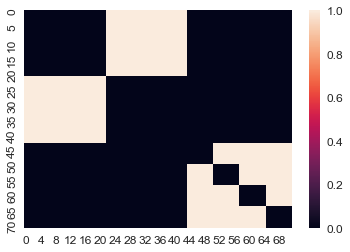

In [36]:
import seaborn as sns

sns.heatmap(mask_self_overlap.astype("int"))

In [37]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_self_ovlp(x, y):
    p = x.copy()
    p[mask_self_overlap] = (y.copy())[mask_self_overlap]
    return p

def embedd_batch_self_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_self_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [39]:
p_embedded_gwh_self_ovlp = embedd_batch_self_ovlp(p_embedded_gwh)

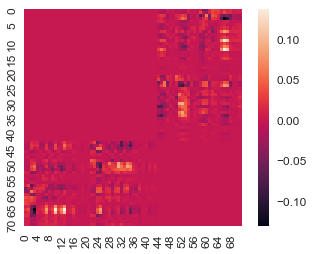

In [41]:
sns.heatmap(p_embedded_gwh_self_ovlp[0] - p_test[0], square=True)

In [66]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_self_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 00:47:09: Iteration calculation: 0
[ ] 2019-01-07 00:47:10: Iteration calculation: 1
[ ] 2019-01-07 00:47:11: Iteration calculation: 2
[ ] 2019-01-07 00:47:12: Iteration calculation: 3
[ ] 2019-01-07 00:47:13: Iteration calculation: 4
[ ] 2019-01-07 00:47:15: Iteration calculation: 5
[ ] 2019-01-07 00:47:16: Iteration calculation: 6
[ ] 2019-01-07 00:47:16: Iteration calculation: 7
[ ] 2019-01-07 00:47:17: Iteration calculation: 8
[ ] 2019-01-07 00:47:18: Iteration calculation: 9
[ ] 2019-01-07 00:47:19: Iteration calculation: 10
[ ] 2019-01-07 00:47:20: Iteration calculation: 11
[ ] 2019-01-07 00:47:21: Iteration calculation: 12
[ ] 2019-01-07 00:47:22: Iteration calculation: 13
[ ] 2019-01-07 00:47:23: Iteration calculation: 14
[ ] 2019-01-07 00:47:23: Iteration calculation: 15
[ ] 2019-01-07 00:47:24: Iteration calculation: 16
[ ] 2019-01-07 00:47:25: Iteration calculation: 17
[ ] 2019-01-07 00:47:27: Iteration calculation: 18
[ ] 2019-01-07 00:47:28: Iteration calcul

[ ] 2019-01-07 00:49:30: Iteration calculation: 160
[ ] 2019-01-07 00:49:31: Iteration calculation: 161
[ ] 2019-01-07 00:49:32: Iteration calculation: 162
[ ] 2019-01-07 00:49:33: Iteration calculation: 163
[ ] 2019-01-07 00:49:35: Iteration calculation: 164
[ ] 2019-01-07 00:49:35: Iteration calculation: 165
[ ] 2019-01-07 00:49:36: Iteration calculation: 166
[ ] 2019-01-07 00:49:36: Iteration calculation: 167
[ ] 2019-01-07 00:49:37: Iteration calculation: 168
[ ] 2019-01-07 00:49:38: Iteration calculation: 169
[ ] 2019-01-07 00:49:39: Iteration calculation: 170
[ ] 2019-01-07 00:49:39: Iteration calculation: 171
[ ] 2019-01-07 00:49:40: Iteration calculation: 172
[ ] 2019-01-07 00:49:41: Iteration calculation: 173
[ ] 2019-01-07 00:49:41: Iteration calculation: 174
[ ] 2019-01-07 00:49:42: Iteration calculation: 175
[ ] 2019-01-07 00:49:43: Iteration calculation: 176
[ ] 2019-01-07 00:49:43: Iteration calculation: 177
[ ] 2019-01-07 00:49:44: Iteration calculation: 178
[ ] 2019-01-

In [69]:
6/(len(p_test))

0.029850746268656716

# Embedded GWH w/ OFF overlap

In [50]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS

mol = molecules[1][0]

mask_off_overlap = np.zeros((dim, dim))

current_dim_i = 0
for i, atom_i in enumerate(mol.species):
    
    
    # calculate block range
    index_start_i = current_dim_i
    current_dim_i += N_BASIS[basis][atom_i] 
    index_end_i = current_dim_i
    
    # calculate logical vector
    L_i = np.arange(dim)
    L_i = np.logical_and(index_start_i <= L_i, L_i < index_end_i)
    
    current_dim_j = 0
    for j, atom_j in enumerate(mol.species):
        

        #print(str(i) + ", " + str(j))    
        #print(str(atom_i) + ", " + str(atom_j))
        
        # calculate block range
        index_start_j = current_dim_j
        current_dim_j += N_BASIS[basis][atom_j] 
        index_end_j = current_dim_j

        if i == j:
            continue
        
        if atom_i != atom_j:
            # calculate logical vector
            L_j = np.arange(dim)
            L_j = np.logical_and(index_start_j <= L_j, L_j < index_end_j)


            m = np.logical_and.outer(L_i, L_j)
            
            mask_off_overlap = np.logical_or(mask_off_overlap, m)
    
#mask

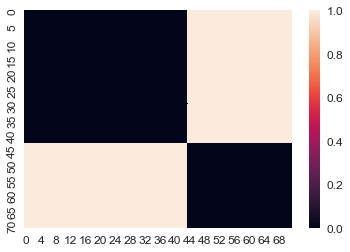

In [51]:
import seaborn as sns

sns.heatmap(mask_off_overlap.astype("int"))

In [52]:
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

def embedd_off_ovlp(x, y):
    p = x.copy()
    p[mask_off_overlap] = (y.copy())[mask_off_overlap]
    return p

def embedd_batch_off_ovlp(p_batch):
    p_embedded = []
    for (p_guess, p_conv) in zip(p_batch, p_test):
        p_embedded.append(embedd_off_ovlp(p_guess, p_conv))
    return np.array(p_embedded)


In [59]:
p_embedded_gwh_off_ovlp = embedd_batch_off_ovlp(p_embedded_gwh)

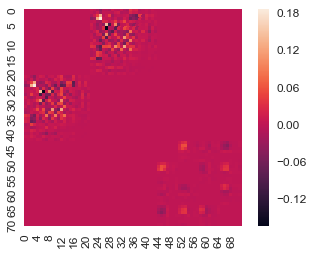

In [60]:
sns.heatmap(p_embedded_gwh_off_ovlp[0] - p_test[0], square=True)

In [67]:
from SCFInitialGuess.utilities.analysis import mf_initializer, make_results_str, measure_all_quantities

print(make_results_str(measure_all_quantities(
    density_from_fock_batch(fock_from_density_batch(p_embedded_gwh_off_ovlp)),
    dataset,
    molecules[1],
    N_ELECTRONS,
    mf_initializer,
    dim,
    is_triu=False,
    is_dataset_triu=False,
    s=S[ind:]
)))

[ ] 2019-01-07 00:53:28: Iteration calculation: 0
[ ] 2019-01-07 00:53:29: Iteration calculation: 1
[ ] 2019-01-07 00:53:29: Iteration calculation: 2
[ ] 2019-01-07 00:53:30: Iteration calculation: 3
[ ] 2019-01-07 00:53:31: Iteration calculation: 4
[ ] 2019-01-07 00:53:32: Iteration calculation: 5
[ ] 2019-01-07 00:53:33: Iteration calculation: 6
[ ] 2019-01-07 00:53:34: Iteration calculation: 7
[ ] 2019-01-07 00:53:35: Iteration calculation: 8
[ ] 2019-01-07 00:53:35: Iteration calculation: 9
[ ] 2019-01-07 00:53:36: Iteration calculation: 10
[ ] 2019-01-07 00:53:36: Iteration calculation: 11
[ ] 2019-01-07 00:53:37: Iteration calculation: 12
[ ] 2019-01-07 00:53:38: Iteration calculation: 13
[ ] 2019-01-07 00:53:38: Iteration calculation: 14
[ ] 2019-01-07 00:53:39: Iteration calculation: 15
[ ] 2019-01-07 00:53:40: Iteration calculation: 16
[ ] 2019-01-07 00:53:41: Iteration calculation: 17
[ ] 2019-01-07 00:53:41: Iteration calculation: 18
[ ] 2019-01-07 00:53:42: Iteration calcul

[ ] 2019-01-07 00:55:37: Iteration calculation: 160
[ ] 2019-01-07 00:55:38: Iteration calculation: 161
[ ] 2019-01-07 00:55:39: Iteration calculation: 162
[ ] 2019-01-07 00:55:39: Iteration calculation: 163
[ ] 2019-01-07 00:55:41: Iteration calculation: 164
[ ] 2019-01-07 00:55:42: Iteration calculation: 165
[ ] 2019-01-07 00:55:42: Iteration calculation: 166
[ ] 2019-01-07 00:55:43: Iteration calculation: 167
[ ] 2019-01-07 00:55:44: Iteration calculation: 168
[ ] 2019-01-07 00:55:45: Iteration calculation: 169
[ ] 2019-01-07 00:55:45: Iteration calculation: 170
[ ] 2019-01-07 00:55:46: Iteration calculation: 171
[ ] 2019-01-07 00:55:47: Iteration calculation: 172
[ ] 2019-01-07 00:55:48: Iteration calculation: 173
[ ] 2019-01-07 00:55:48: Iteration calculation: 174
[ ] 2019-01-07 00:55:49: Iteration calculation: 175
[ ] 2019-01-07 00:55:50: Iteration calculation: 176
[ ] 2019-01-07 00:55:50: Iteration calculation: 177
[ ] 2019-01-07 00:55:51: Iteration calculation: 178
[ ] 2019-01-

In [70]:
7/len(p_test)

0.03482587064676617